In [1]:
import math
import random
from IPython.display import clear_output
from IPython.display import HTML
from IPython.display import display
from numbers  import Number
from multiprocessing import Pool
from matplotlib import pyplot as plt
from matplotlib import colors as pltcolors
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
import numpy as np
from celluloid import Camera

In [2]:
def simulate_exact(v: Number, p: Number, bounce1: Number, bounce2: Number, Δt: Number, g:Number, hit=False) -> (Number, Number): 
    """Simulates the ball with a specific velocity v and position p. 
    Parameters:
        v: velocity
        p: height
        bounce1: fraction of velocity preserved when it bounces
        bounce2: fraction of velocity preserved when its hit by the bat
        Δt: timestep
        hit: The action. Whether or not to attempt to hit the ball.
    Returns:
        (v, p): new v and p after timestep Δt"""
    new_v, new_p = None, None  # Result
    v0, p0 = v, p              # To avoid changing argument values
    
    if hit and p >= 4: # Hitting the ball changes the velocity
        if v < 0: 
            v0 = min(v, -4)
        else:
            v0 = -bounce2*v - 4
    
    # Free fall
    new_v = g * Δt + v0
    new_p = 0.5 * g * Δt**2 + v0 * Δt + p0
    
    
    if new_p <= 0: # Hitting the ground
        # Need to establish the exact time t it hits the ground:  0 = 0.5 * g * t**2 + v0 * t + p0
        # This type of equation can have two soutions: t  = (-v0 ± sqrt(v0**2 - 2*g*p0))/g
        #     t1 = (-v0 + sqrt(v0**2 - 2*g*p0))/g
        #     t2 = (-v0 - sqrt(v0**2 - 2*g*p0))/g 
        # In this case, t2 is always the solution. 
        # Proof: t must be positive since the impact occured this timestep.
        #        p0 >= 0 and g < 0 therefore -2*g*p0 >= 0
        #        So therefore abs(v0) <= sqrt(v0**2 - 2*g*p0)
        #        And the ball must have a negative velocity v0 < 0 to hit the ground
        #        So that (-v0 - sqrt(v0**2 - 2*g*p0)) < 0
        #        And divided by g which is also negative we have that 
        #        (-v0 - sqrt(v0**2 - 2*g*p0))/g > 0
        

        #print(f"v0 = {v0:.2f}\tp0 = {p0:.2f}\tt1 = {t1:.2f}\tt2 = {t2:.2f}\tnew_p = {new_p:.2f}")
        #print(f"discriminant = v0**2 - 2*g*p0 = {discriminant:.2f}")
        #print(f"t1 = (-v0 + math.sqrt(v0**2 - 2*g*p0))/g = ({-v0:.2f} + {math.sqrt(v0**2 - 2*g*p0):.2f})/{g:.2f} = {t1:.2f}")
        #print(f"t2 = (-v0 - math.sqrt(v0**2 - 2*g*p0))/g = ({-v0:.2f} - {math.sqrt(v0**2 - 2*g*p0):.2f})/{g:.2f} = {t2:.2f}")
        #print()
        t_impact = (-v0 - math.sqrt(v0**2 - 2*g*p0))/g 
        t_remaining = Δt - t_impact       # Time left this timestep after bounce occurs
        
        new_v = g * t_impact + v0         # Gravity pull before bounce
        
        new_v = -bounce1 * new_v          # Bounce
        
        new_v = g * t_remaining + new_v   # Gravity pull after bounce
        new_p = 0.5 * g * t_remaining**2 + new_v * t_remaining + 0  # Jump height after bounce
        if new_p <= 0:           # If it hits the ground twice within the same timestep, 
            new_v, new_p = 0, 0  # simply put the ball to a stop.
    
    return new_v, new_p

In [31]:
class Grid:
    def __init__(self, G, g, v_min, p_min, v_max, p_max):
        self.G = G
        self.g = g
        self.v_min = v_min
        self.p_min = p_min
        self.v_max = v_max
        self.p_max = p_max
        self.v_count = int((v_max - v_min)/G)
        self.p_count = int((p_max - p_min)/G)
        self.array = np.zeros((self.v_count, self.p_count), dtype=np.int8)
        self.transition_graininess = 4

    def draw(self, f=None, show_grid=True, grid_color="white", square_types=[("lightgreen", "Any action"), ("lightyellow", "Must hit"), ("salmon", "Bad")]):
        # I hate matplotlib
        self.cmap = pltcolors.ListedColormap([c for c, _ in square_types])
        self.boundaries = range(0, len(square_types)+1)
        self.norm = pltcolors.BoundaryNorm(self.boundaries, self.cmap.N, clip=True)
        
        if f == None:
            f = plt.figure()
            f.set_figwidth(10)
            f.set_figheight(10)
        image = plt.imshow(self.array.transpose(), origin="lower", cmap=self.cmap, norm=self.norm, extent=[self.v_min, self.v_max, self.p_min, self.p_max])
        
        ax = plt.gca()
        ax.set_xlabel("v")
        ax.set_ylabel("p")
        
        # Fake grid
        if show_grid:
            plt.vlines(np.arange(self.v_min, self.v_max, self.G), self.p_min, self.p_max, color=grid_color, linewidth=0.5)
            plt.hlines(np.arange(self.p_min, self.p_max, self.G), self.v_min, self.v_max, color=grid_color, linewidth=0.5)
        
        plt.hlines([0], self.v_min, self.v_max, color="black")
        
        # Legend
        values = range(0, len(square_types))
        labels = [d for _, d in square_types]
        colors = [ image.cmap(image.norm(value)) for value in values]
        plt.legend(handles=[mpatches.Patch(color=colors[x], label=f"{labels[x]}") for x in range(len(values))])
    
    def box(self, v, p):
        if v < self.v_min or v > self.v_max:
            raise IndexError("v value out of bounds.")
        if p < self.p_min or p > self.p_max:
            raise IndexError("p value out of bounds.")

        iv = int((v - self.v_min)/self.G)
        ip = int((p - self.p_min)/self.G)
        return iv, ip
    
    def square_within_bounds(self, square):
        a, b = square
        return 0 <= a < self.v_count and 0 <= b < self.p_count
    
    def value_within_bounds(self, v, p):
        return self.v_min <= v <= self.v_max and self.p_min <= p <= self.p_max
    
    def bounds(self, square):
        iv, ip = square
        Ivl, Ipl = self.G * iv + self.v_min, self.G * ip + self.p_min
        Ivu, Ipu = self.G * (iv+1) + self.v_min, self.G * (ip+1) + self.p_min
        return Ivl, Ivu, Ipl, Ipu
    
    def transition(self, square, t, action):
        return self.pragmatic_transition(square, t, action, self.transition_graininess)
    
    def pragmatic_transition(self, square, t, action, graininess):
        result = set()
        
        Ivl, Ivu, Ipl, Ipu =  self.bounds(square)
        
        # Fuck the world.
        for v in (np.linspace(Ivl, Ivu, graininess)):
            for p in (np.linspace(Ipl, Ipu, graininess)):
                w, q = simulate_exact(v, p, 0.85, 0.90, t, self.g, action)
                
                result.add((int((w - self.v_min)/self.G), 
                            int((q - self.p_min)/self.G)))
        
        result = {(s) for s in result if self.square_within_bounds(s)}
        
        return result
    
    def __getitem__(self, item):
        return self.array[item]
        
    def __setitem__(self, item, newvalue):
        self.array[item] = newvalue
        
    def __iter__(self):
        self.iter_iv = 0
        self.iter_ip = 0
        return self
    
    def __next__(self):
        if self.iter_ip >= self.p_count:
            if self.iter_iv >= self.v_count - 1:
                raise StopIteration
            else:
                self.iter_iv += 1
                self.iter_ip  = 0
        
        iv, ip = self.iter_iv, self.iter_ip
        self.iter_ip += 1
        return iv, ip
    
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            for s in self:
                if other[s] != self[s]:
                    return False
            return True
        else:
            return False

    def __ne__(self, other):
        return not self.__eq__(other)

In [32]:
grid7 = Grid(1, -9.81, -10, 0, 10, 10)
[s for s in grid7]

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7),
 (7, 8),
 (7, 9),
 (8, 0),
 (8, 1),
 (8, 2),
 (8, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 8),
 (8, 9),
 (9, 0),
 (9, 1),
 (9, 2),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 6),
 (9, 7),
 (9, 8),
 (9, 9),
 (10, 0),
 (10, 1),
 (10, 2),
 (10, 3),
 (10, 4),
 (10, 5),
 (10, 6),
 (10, 7),
 (10, 8),
 (10, 9),


example_v, example_p = (8.54543714678385, 6.549216322850584)
example_u, example_q = (5.602437146783851, 8.67139746688574)



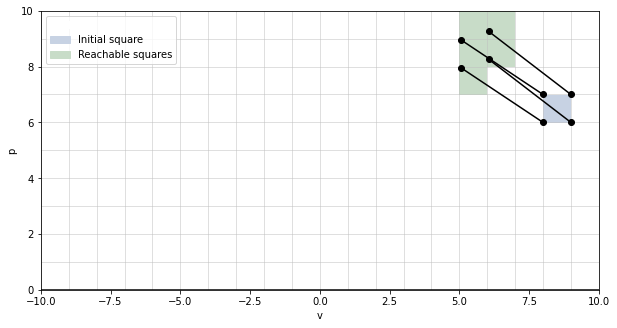

In [4]:
# Show the transition function
grid6 = Grid(1, -9.81, -10, 0, 10, 10)

t = 0.3

example_v, example_p = random.uniform(grid6.v_min, grid6.v_max), random.uniform(grid6.p_min, grid6.p_max)
example_u, example_q = simulate_exact(example_v, example_p, 0.85, 0.90, t, grid6.g, False)

print(f"example_v, example_p = {example_v, example_p}")
print(f"example_u, example_q = {example_u, example_q}\n")

square = grid6.box(example_v, example_p)

grid6[square] = 1
for s in grid6.transition(square, t, False):
    grid6[s] = 2

grid6.draw(grid_color="#c0c0c0", square_types=[("white", ""), ("#c7d2e3", "Initial square"), ("#c8dcc8", "Reachable squares")])


Ivl, Ivu, Ipl, Ipu = grid6.bounds(square)
for v, p in [(v, p) for v in [Ivl, Ivu] for p in [Ipl, Ipu]]:
    w, q = simulate_exact(v, p, 0.85, 0.90, t, grid6.g, False)
    plt.plot([v, w], [p, q], color="black", marker="o")
plt.show()

In [5]:
minimum_E_mek = 54.3113

def E_kin(v):  # Assuming mass of the ball is 1
    return 0.5*abs(v)**2

def E_pot(p):
    return abs(g)*p

def E_mek(v, p):
    return E_kin(v) + E_pot(p)

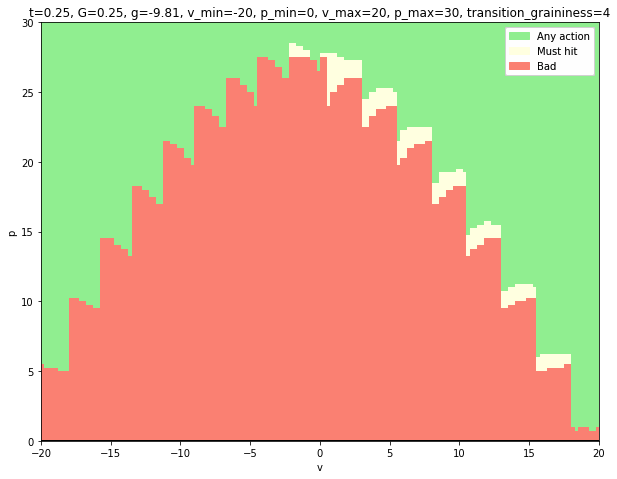

In [36]:
spinner1 = "🌑🌒🌓🌔🌕🌖🌗🌘"
spinner2 = "🌍🌏🌎"

t = 0.25
G, g, v_min, p_min, v_max, p_max = 0.25, -9.81, -20, 0, 20, 30
transition_graininess = 4

show_grid = False

grid = Grid(G, g, v_min, p_min, v_max, p_max)
grid.transition_graininess = transition_graininess

any_action, must_hit, bad = 0, 1, 2

for s in grid:
    Ivl, Ivu, Ipl, Ipu = grid.bounds(s)
    if E_mek(Ivl, Ipl) < minimum_E_mek:
        grid[s] = bad

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
plt.title(f"t={t:.2f}, G={G:.2f}, g={g:.2f}, v_min={v_min}, p_min={p_min}, v_max={v_max}, p_max={p_max}, transition_graininess={transition_graininess}")
grid.draw(f=fig, show_grid=show_grid)
display(fig)
camera = Camera(fig)

loop_break = 1000

try: 
    while True:
        loop_break -= 1
        grid2 = Grid(G, g, v_min, p_min, v_max, p_max)


        def get_color(s):
            if grid[s] == bad:
                return bad
            no_hit = grid.transition(s, t, False)

            if any([s2 for s2 in no_hit if grid[s2] == bad]):
                hit = grid.transition(s, t, True)
                if any([s2 for s2 in hit if grid[s2] == bad]):
                    return bad # TODO: the rest of the transitin function
                else:
                    return must_hit
            else:
                return any_action
        
        with Pool(5) as p:
            colors = np.array(p.map(get_color, [s for s in grid]))
        grid2.array = colors.reshape(grid.v_count, grid.p_count)

        grid.draw(f=fig, show_grid=show_grid)
        camera.snap()
        clear_output(wait=True)
        display(fig)
        print(f"{spinner1[loop_break%len(spinner1)]}")

        if loop_break <= 0 or grid == grid2:
            break

        grid = grid2

except KeyboardInterrupt:
    print("Computation cancelled early. Rendering...")

clear_output(wait=True)
plt.show()
animation = camera.animate(blit=True, interval=400, repeat=True, repeat_delay=2000)
HTML(animation.to_html5_video())

In [16]:
colors.reshape(grid.v_count, grid.p_count).transpose()

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
def shield(grid, action, v, p):
    if not grid.value_within_bounds(v, p):
        return action
    
    if grid[grid.box(v, p)]== must_hit:
        return True
    else:
        return action

shield(grid, False, 0, 10)

In [ ]:
Δt = 0.01

v, p = 0, 35#0, random.randint(7, 10)
time, velocity, position = [0], [v], [p]

for i in range(int(15/Δt)):
    action = False
    action = shield(grid, action, v, p)
    v, p =  simulate_exact(v, p, 0.85, 0.90, Δt, grid.g, False)
    time.append(i*Δt+Δt)
    velocity.append(v)
    position.append(p)


f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
plt.xlabel("t")
plt.ylabel("p")
plt.axhline(4, color="lightgray")
plt.axhline(0, color="lightgray")
grid.draw(f=f, show_grid=show_grid)
plt.plot(velocity, position, marker=".", color="black")
plt.show()